In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Domanda 1

Si scriva una funzione che simuli il cammino degli abitanti del villaggio dopo aver bevuto la grappa,
assumendo che si spostino in piano, che ogni passo abbia direzione casuale uniforme angolarmente
ed una lunghezza distribuita secondo una distribuzione Gaussiana con media 1 e larghezza 0.2,
troncata a valori positivi.

In [2]:
from myrand import generate_range, rand_TCL_ms

In [3]:
def walk(N):                                
            
    #tronco la gaussiana ai valori positivi
    steps = []
    for i in range(N):
        step = rand_TCL_ms(1, 0.2) 
        if step <= 0: steps.append(0)
        if step > 0: steps.append(step)
   
    angles = generate_range(0, 2*np.pi, N)      #angoli associati alla direzione 
    dx = steps*np.cos(angles)                   #componente x del passo
    dy = steps*np.sin(angles)                   #componente y del passo
    x = np.cumsum(dx)                           #posizione sulle x
    y = np.cumsum(dy)                           #posizione sulle y
    dist = ((x[N-1])**2 + (y[N-1])**2)** 0.5    #distanza da (0,0)
    return x, y, dist

# Domanda 2

Immaginando che il calderone si trovi alle coordinate (0, 0) sul piano, si scriva una funzione che
calcoli la posizione (x, y) raggiunta da Asterix dopo N = 10 passi e si disegni il suo percorso.

La posizione di Asterix è: (-3.86, -1.77)


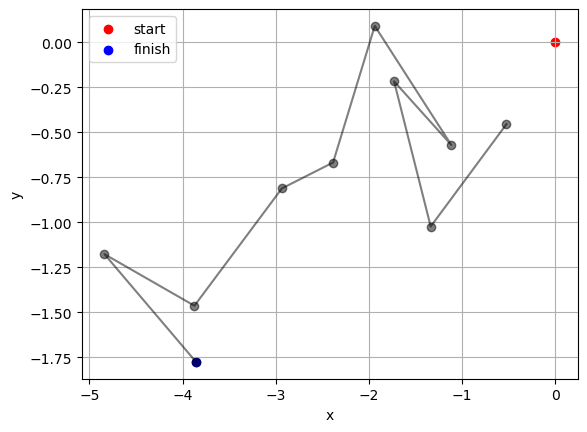

In [16]:
N = 10
x, y, dist = walk(N)
max_x = x[N-1]
max_y = y[N-1]
print(f'La posizione di Asterix è: ({max_x:.2f}, {max_y:.2f})')

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.plot(x, y, marker = 'o', color = 'black', alpha = 0.5);
plt.scatter([0], [0], color = 'red', label = 'start')
plt.scatter(x[N-1], y[N-1], color = 'blue', label = 'finish')
ax.set_ylabel('y');
ax.set_xlabel('x');
plt.grid()
plt.legend();

# Domanda 3

Si consideri ora l’intera popolazione: si determini la posizione (x, y) di ogni abitante dopo N =
10 passi a partire dal calderone e si disegni le distribuzione della distanza raggiunta dal punto di
partenza, assumendo la popolazione totale composta da 10000 persone.

In [17]:
from mix import sturges

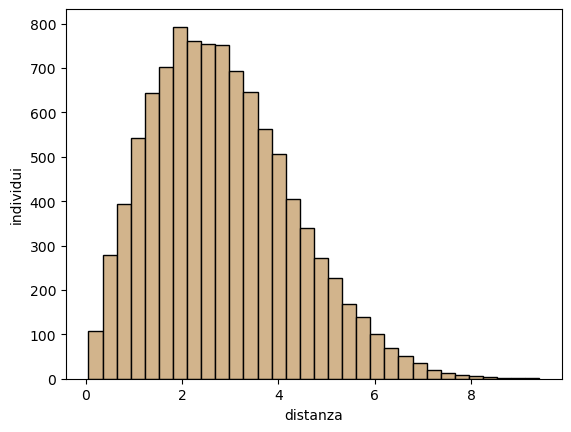

In [27]:
N_toy = 10000

distance = []

# tramite un toy experiment simulo 10 passi di 10000 abitanti

for i in range(N_toy):
  N = 10
  x, y, dista = walk(N)
  distance.append(dista)

# effettuo l'operazione di binning

bin = sturges(N_toy)
bin_content, bin_edges = np.histogram(distance, bin)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(distance, bin_edges, edgecolor = 'black', color = 'tan');
ax.set_xlabel('distanza');
ax.set_ylabel('individui');

# Domanda 4

Si determinino media, varianza, asimmetria e curtosi della distribuzione ottenuta.

In [28]:
from stats import stats

In [29]:
#applico ai dati una classe che calcoli automaticamente i valori

stat = stats(distance)
mean = stat.mean()
var = stat.variance()
asi = stat.skewness()
kurt = stat.kurtosis()

print(f'Media: {mean:.3f}\n')
print(f'Varianza: {var:.3f}\n')
print(f'Asimmetria: {asi:.3f}\n')
print(f'Curtosi: {kurt:.3f}\n')

Media: 2.853

Varianza: 2.141

Asimmetria: 0.572

Curtosi: 0.069



# Domanda 5

Se la lunghezza dei passi è costante uguale ad 1, la distribuzione delle distanze r dopo N passi segue
una distribuzione di Rayleigh.
Si utilizzi un fit per determinare, a partire dalla distribuzione di distanze costruita in queste ipotesi,
il numero di passi effettuati, sapendo che la distribuzione di Rayleigh è presente in scipy come
scipy.stats.rayleigh e che per ottenere la forma funzionale di interesse per il problema questa
distribuzione ha come parametri loc = 0 e scale = √N/2 (dove N è il numero di passi).

In [30]:
def walk_1(N):
    steps = np.full(N, 1)                      #lunghezza dei passi costante
    angles = generate_range(0, 2*np.pi, N)     #angoli associati alla direzione          
    dx = steps*np.cos(angles)                  #spostamento su x
    dy = steps*np.sin(angles)                  #spostamento su y
    x = np.cumsum(dx)                          #posizione x
    y = np.cumsum(dy)                          #posizione y
    dist = ((x[N-1])**2 + (y[N-1])**2)** 0.5   #distanza da (0,0)
    return dist

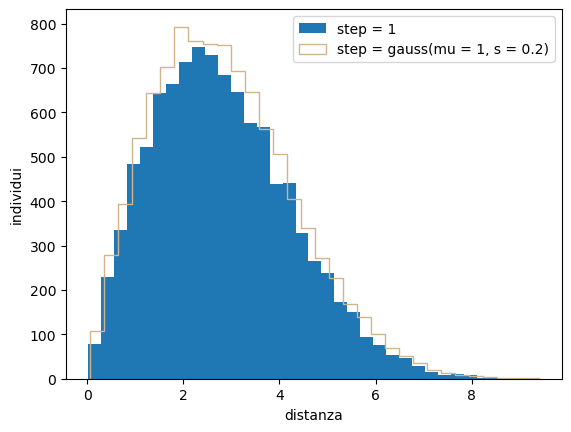

In [51]:
#ripeto il toy, ora con passi di lunghezza costante

distanc = []

for i in range(N_toy):
  dist = walk_1(N)
  distanc.append(dist)

bin_content2, bin_edges2 = np.histogram(distanc, bin)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(distanc, bin_edges2, label = 'step = 1');
ax.hist(distance, bin_edges, histtype = 'step', color = 'tan', label = 'step = gauss(mu = 1, s = 0.2)');
ax.set_xlabel('distanza');
ax.set_ylabel('individui');
ax.legend();

In [52]:
from scipy.stats import rayleigh
from iminuit import Minuit
from iminuit.cost import ExtendedBinnedNLL

In [53]:
def mod_total(bin_edges, N_signal, n):                        
    return N_signal * rayleigh.cdf(bin_edges, 0, np.sqrt(n/2))

my_cost_func = ExtendedBinnedNLL(bin_content2, bin_edges2, mod_total) 
fit = Minuit(my_cost_func, N_signal = N_toy, n = 10)

fit.migrad()
fit.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 39.99 (χ²/ndof = 1.3)      │              Nfcn = 34               │
│ EDM = 2.19e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal │  10.01e3  │  0.10e3   │            │            │         │         │       │
│ 1 │ n        │   9.99    │   0.10    │            │            │         │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────┐
│          │ N_signal        n │
├──────────┼───────────────────┤
│ N_signal │    1e+04    0.043 │
│        n │    0.043   0.0103 │
└──────────┴───────────────────┘

In [54]:
est = fit.values['n']
print(f'Numero di passi stimato a partire dai dati: {est:.3f}')

Numero di passi stimato a partire dai dati: 9.992
